<a href="https://colab.research.google.com/github/ssv273/computer_vision/blob/master/HW_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка видео
Классификация действий по видео


## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tqdm.notebook import tqdm

In [3]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

## Загрузка и распаковка датасета KTH

In [7]:
if 1:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

--2020-05-03 10:15:43--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2020-05-03 10:15:44--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.227.116
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.227.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘walking.zip’

walking.zip             [     <=>            ] 231.21M  7.95MB/s    in 31s     

2020-05-03 10:16:16 (7.44 MB/s) - ‘walking.zip’ saved [242442411]

--2020-05-03 10:16:17--  http://www.nada.kth.se/cvap/actions/jogging.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::

In [0]:
!rm *.zip

## Подготовка датасета для классификации

In [4]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [10]:
SUBSET_LEN = 200
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 200


посмотрим на размеры наших видеофайлов

In [11]:
%%time
shapes = []
for i in range(len(dataset)):
    videodata = skvideo.io.vread(dataset[i][0])
    shapes.append(videodata.shape)

CPU times: user 4.66 s, sys: 4.93 s, total: 9.59 s
Wall time: 43.6 s


In [12]:
print('Всего файлов {}\nМинимальное количество кадров {}\nМаксимальное количетво кадров {}'.format(len(shapes),sorted(shapes)[0][0], sorted(shapes)[-1][0]))

Всего файлов 200
Минимальное количество кадров 230
Максимальное количетво кадров 888


как мы видим - у нас разное количество кадров в роликах, есть совсем маленькие, есть совсем большие

итак, что мы сделаем: мы возьмем ролики и повторим каждый из них до максимального количества кадров

In [0]:
# MAX_FRAMES = sorted(shapes)[-1][0]
MAX_FRAMES = 600

Напишем функцию, которая будет повторять ролик сам в себя до необходимого нам количества раз

In [0]:
def reshape_(np_video):
  tmp = np_video.copy()
  # если количество кадров в видео меньше максимального
  if np_video.shape[0] < MAX_FRAMES:
    # то определяем сколко раз надо повторить операцию vstack
    num_iter = round(MAX_FRAMES / np_video.shape[0]) + 1
    # создаем временный файл, в котором будем хранить повторы
    tmp = np_video.copy()
    # стакаем необходимое количество раз
    for iterations in range(num_iter):
      tmp = np.vstack((tmp, np_video))
      if tmp.shape[0] > MAX_FRAMES:
        break
    # так как мы повторяли ролик сам в себя несколько раз, то его длина может быть больше чем необходимая
    # поэтому возьмем только необходимое нам количество кадров
    tmp = tmp[:MAX_FRAMES, ...]
  return tmp

Теперь преобразуем каждый ролик до нужного нам размера и запишем его

In [15]:
if 1:
  for data in tqdm(dataset):
    path = data[0][:-3]
    np_video = skvideo.io.vread(data[0])
    new_video = reshape_(np_video)
    skvideo.io.vwrite(path + "mp4", new_video)

Теперь сделаем новый датасет

In [16]:
dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.mp4')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [17]:
%%time
shapes = []
for i in range(len(dataset)):
    videodata = skvideo.io.vread(dataset[i][0])
    shapes.append(videodata.shape)

CPU times: user 7.05 s, sys: 7.75 s, total: 14.8 s
Wall time: 1min 4s


In [18]:
print('Всего файлов {}\nМинимальное количество кадров {}\nМаксимальное количетво кадров {}'.format(len(shapes),sorted(shapes)[0][0], sorted(shapes)[-1][0]))

Всего файлов 200
Минимальное количество кадров 600
Максимальное количетво кадров 888


Ну вот, чего мы собственно и добивались

## Визуализация кадра из видео

videodata shape: (888, 120, 160, 3)


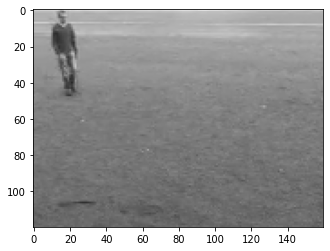

In [19]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...]);

## Визуализация "движения"

motion shape: (887, 120, 160, 1)


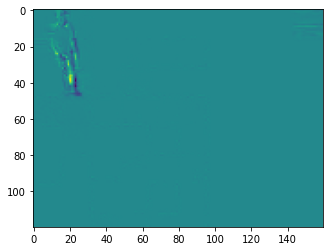

In [20]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

# Создание датасета

In [5]:
paths_ = []
labels_ = []

data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.mp4')):
        cls_idx = classes.index(cls)
        paths_.append(fpath)
        labels_.append(cls_idx)

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


Создадим функцию, которая бует считывать в датасет видеофайлы

In [0]:
def read_(fpath):
  video_to_np = skvideo.io.vread(fpath.numpy().decode())
  video_to_np = tf.cast(video_to_np, tf.float32) / 255
  return video_to_np

In [0]:
def tf_item_to_data(path, label):
    videodata = tf.py_function(read_, [path], [tf.float32])
    return videodata, label

In [0]:
import random

tmp_list = list(zip(paths_, labels_))
random.shuffle(tmp_list)

paths_, labels_ = zip(*tmp_list)

train_len = int(len(paths_) * 0.9)

paths_train = list(paths_[:train_len])
labels_train = list(labels_[:train_len])

paths_test = list(paths_[train_len:])
labels_test = list(labels_[train_len:])

In [0]:
BATCH_SIZE = 1
NUM_EPOCHS = 10

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((paths_train, labels_train))

In [0]:
test_ds = tf.data.Dataset.from_tensor_slices((paths_test, labels_test))

In [12]:
%%time
train_ds = train_ds.map(tf_item_to_data)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
# train_ds = train_ds.batch(BATCH_SIZE)

CPU times: user 73.8 ms, sys: 0 ns, total: 73.8 ms
Wall time: 106 ms


In [13]:
%%time
test_ds = test_ds.map(tf_item_to_data)
test_ds = test_ds.shuffle(buffer_size=1000)
# test_ds = test_ds.batch(BATCH_SIZE)

CPU times: user 7.19 ms, sys: 3.73 ms, total: 10.9 ms
Wall time: 9.32 ms


# Создание модели

In [0]:
def build_model():

  x = tf.keras.layers.Input((None, None, None, 1))

  out1 = tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu')(x)
  out1 = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out1)
  out1 = tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu')(out1)
  out1 = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out1)
  out1 = tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu')(out1)
  out1 = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out1)
  out1 = tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None)(out1)
  out1 = tf.keras.layers.GlobalAveragePooling3D()(out1)
  out1 = tf.keras.layers.Dense(64, activation='relu')(out1)
  out1 = tf.keras.layers.Dense(6, activation=None)(out1)

  return tf.keras.Model(inputs=x, outputs=out1)


In [0]:
model = build_model()

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, None, 0         
_________________________________________________________________
conv3d (Conv3D)              (None, None, None, None,  4032      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, None, None, None,  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, None, None, None,  256064    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, None, None, None,  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, None, None, None,  110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, None, None, None,  0     

In [0]:
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

In [0]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = 'logs/my_model_batch1_all200',
    write_graph=False, 
    update_freq=100,
    profile_batch=0
)

In [0]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    # validation_data=test_ds,
    callbacks=[tensorboard_callback]
)

Epoch 1/10


In [0]:
writer = tf.summary.create_file_writer('logs/exp1')

In [0]:


%%time

import time

global_step = 0

best_loss = 999999999.9

EPOCHS = 20

st_time = time.time()
for epoch in range(EPOCHS):
    print("|"*70,"\nTime from prev epoch: %.3f seconds" % (time.time() - st_time), flush=True)
    print("|"*70, flush=True)
    st_time = time.time()
    
    for i, batch in enumerate(train_ds):
        loss_value = model.train_on_batch(x=batch[0], y=batch[1])

        if i % 1 == 0:
            print("Epoch #%d" % epoch, "#%d/%d;" % (i, len(paths_train)), "Loss: %.10f" % loss_value, flush=True)
            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)
                
        if loss_value < best_loss:
            print("="*50, flush=True)
            print("New best loss. Save model", flush=True)
            print("Epoch #%d" % epoch, "#%d/%d;" % (i, len(paths_train)), "Loss: %.10f" % loss_value, flush=True)
            print("="*50, flush=True)
            best_loss = loss_value
            model.save("best_model.h5")
            with open("best_loss.txt", "wt") as best_loss_file:
                best_loss_file.write("Best loss value: %.10f\n" % loss_value)
                best_loss_file.write("Epoch: %d\n" % epoch)
                best_loss_file.write("i: %d\n" % i)
            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)
        
        global_step += 1



# Сегодня доделаю
